# Analysis of taxi trips

@Liubov, Alexey notebooks for WWCS

Notebook for the winter school WWCS for analysis of mobility data. 
It consist of several parts: 
1. locations analysis for spatial analysis 
2. temporal analysis of trips distributions 
3. general properties: such as scaling etc. 

Here we consider the data of taxi drivers in New York [1]. For possible statistics and measures one can look at [2]. I also acknoledge help of C.Singh for important insights about the dataset.

Some suggested references:
1. Kaggle dataset to download https://www.kaggle.com/c/new-york-city-taxi-fare-prediction 
2. Yellow cabs analysis https://arxiv.org/abs/1508.07292

In [2]:
from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


# 1. Locations analysis for spatial analysis 

# Loading data

Initially, we have the dataset of transportation of taxis around NY from open Kaggle dataset.
However it is easier to work with smaller datasets.
There are several **datasets:**
1. full dataset 
2. dataset prepared by C.Singh and split into 6 time-zones datasets: 0:00-4:00, 4:00-8:00, 8:00-12:00, 12:00-16:00, 16:20, 20:00-24:00.

In [3]:

df = pd.read_csv('taxi_test.csv',sep=',')
print(df.shape)

df.head()



(625134, 9)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Let us read separate data-sets with $0:00-4:00$ and $8:00-12:00$ for making plots for spatial distribution.

In [4]:
#load data for time period 0:00-4:00 
#load data for time period 8:00-12:00

filepath_data = "C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/time_zones/time_zone_1.csv" 
df_1 = pd.read_csv(filepath_data,sep=' ')
print(df_1.shape)

filepath_data = "C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/time_zones/time_zone_3.csv" 
df_3 = pd.read_csv(filepath_data,sep=' ')

print(df_3.shape)
df_3.head()

(268629, 9)


,tripID,Date,Time,Distance,Duration,pick_long,pick_lat,drop_long,drop_lat
0,id3858529,2016-01-19,11:35:24,6.380,2124,-73.979027,40.763939,-74.005333,40.710087
1,id1299289,2016-05-15,11:16:11,3.777,1128,-73.991531,40.749439,-73.956543,40.770630
2,id1187965,2016-02-19,09:52:46,1.864,1114,-73.962982,40.756680,-73.984406,40.760719
3,id1154431,2016-04-14,08:48:26,2.536,731,-73.994255,40.745804,-73.999657,40.723343
4,id3552682,2016-06-27,09:55:13,4.603,1317,-74.003983,40.713013,-73.979195,40.749924


# Filtering data
Filter the data for distance more than 20, less than 21 km. 


In [7]:

df_new = df_3[df_3.Distance > 20]
df_new = df_new[df_new.Distance <= 21]

print(df_new.shape)
df_new.head()

(1495, 9)


,tripID,Date,Time,Distance,Duration,pick_long,pick_lat,drop_long,drop_lat
6,id3321406,2016-06-03,08:15:05,20.612,2485,-73.955231,40.777134,-73.788750,40.641472
138,id2833082,2016-06-14,09:03:49,20.934,2743,-73.992584,40.737293,-73.776764,40.644833
277,id1629416,2016-02-29,10:04:11,20.304,3345,-73.786102,40.639755,-74.003876,40.716850
562,id0296060,2016-06-16,08:07:39,20.426,7440,-73.779083,40.647491,-74.006996,40.708523
587,id1301899,2016-04-22,11:04:50,20.925,2736,-73.781807,40.644806,-73.956108,40.778648


We make new variable from "duration" field variables (in minutes) and filter out trips with not longer than $86.14$ minutes (quantile of $75\%$).

In [10]:

df_new["Duration(min)"] = df_new["Duration"]/60

q1 = df_new["Duration(min)"].quantile(0.25)
q3 = df_new["Duration(min)"].quantile(0.75)
iqr = q3-q1
low_end = max(q1 - 1.5*iqr,0)
high_end = q3 + 1.5*iqr

print(low_end, high_end)

df_new = df_new[df_new["Duration(min)"] <= high_end]
print(df_new.shape)

df_new.sort_values("Duration(min)")

1.88333333333334 86.14999999999999
(1450, 11)


,tripID,Date,Time,Distance,Duration,pick_long,pick_lat,drop_long,drop_lat,Duration(seconds),Duration(min)
64696,id1247921,2016-01-11,11:56:08,20.657,840,-73.784966,40.648548,-73.956734,40.780918,14.000000,14.000000
45667,id2617414,2016-03-20,08:53:43,20.734,1045,-73.929337,40.799358,-73.791794,40.644730,17.416667,17.416667
249656,id1261113,2016-02-14,09:45:22,20.203,1164,-73.972603,40.749142,-73.776352,40.645279,19.400000,19.400000
167522,id1063807,2016-01-01,09:52:20,20.038,1205,-73.976379,40.744179,-73.778358,40.644970,20.083333,20.083333
115417,id0787003,2016-02-28,08:49:28,20.145,1235,-73.985603,40.746841,-73.789932,40.643261,20.583333,20.583333
...,...,...,...,...,...,...,...,...,...,...,...
10450,id2148371,2016-04-22,11:17:31,20.724,5120,-73.790039,40.643860,-74.004562,40.734200,85.333333,85.333333
40229,id0979629,2016-05-15,10:30:03,20.058,5124,-73.776482,40.645172,-73.975853,40.743141,85.400000,85.400000
173324,id3806562,2016-05-06,09:10:31,20.804,5139,-73.974998,40.756279,-73.776314,40.645679,85.650000,85.650000
25753,id1476723,2016-04-12,08:36:34,20.494,5150,-73.800407,40.645950,-74.008598,40.740540,85.833333,85.833333


# Plotting
First let us plot the whole dataset.
Plotting geographic locations of the trips. For this we use BBox with latitude and longitude coordinates $(-74.1859, -73.6826, 40.4485, 40.9234)$. 
We plot separately 
1. drop-off and pickup locations
2. connections between drop-off and pickup locations

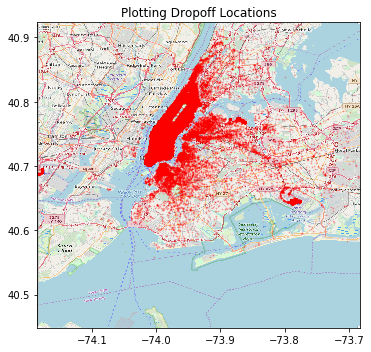

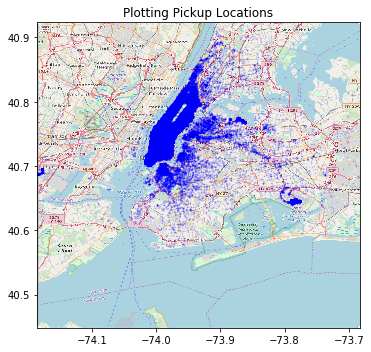

In [14]:

BBox = (-74.1859, -73.6826, 40.4485, 40.9234) # BBox = (-74.0293, -73.8939, 40.6982, 40.8687)

file_path_png = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/nyc.png'
file_save_path = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/plots_jupyter/'

#nyc = plt.imread('')
nyc = plt.imread(file_path_png)

x_pos, y_pos = list(df.pick_long), list(df.pick_lat)
x_f,y_f = list(df.drop_long), list(df.drop_lat)

d_x = list(map(lambda x: x[0]-x[1], zip(x_f,x_pos)))
d_y = list(map(lambda x: x[0]-x[1], zip(y_f,y_pos)))

fig, ax = plt.subplots(figsize = (8,5))
# ax.scatter(df.pick_long, df.pick_lat, zorder=2, alpha= 0.2, c='b', s=15)
ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=0.5)
ax.set_title('Plotting Dropoff Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'dropoff.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df.drop_long, df.drop_lat, zorder=2, alpha= 0.2, c='b', s=0.5)
# ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=15)
ax.set_title('Plotting Pickup Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'pickup.png')
plt.show()



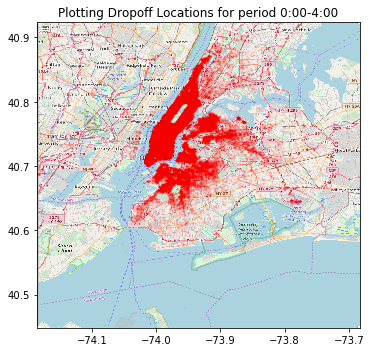

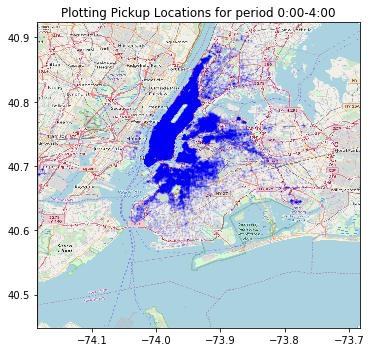

In [14]:

# load image we will be plotting on
BBox = (-74.1859, -73.6826, 40.4485, 40.9234) # BBox = (-74.0293, -73.8939, 40.6982, 40.8687)
#file_path_png = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/nyc.png'
file_save_path = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/plots_jupyter/'

file_path = '/home/user1/Documents/Data_Analysis/nyc/'
nyc = plt.imread(file_path+ 'nyc.png')


x_pos, y_pos = list(df_1.pick_long), list(df_1.pick_lat)
x_f,y_f = list(df_1.drop_long), list(df_1.drop_lat)

d_x = list(map(lambda x: x[0]-x[1], zip(x_f,x_pos)))
d_y = list(map(lambda x: x[0]-x[1], zip(y_f,y_pos)))

fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df_1.drop_long, df_1.drop_lat, zorder=1, alpha= 0.1, c='r', s=0.5)
ax.set_title('Plotting Dropoff Locations for period 0:00-4:00')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'plots_jupyter/dropoff.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df_1.drop_long, df_1.drop_lat, zorder=2, alpha= 0.1, c='b', s=0.5)
# ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=15)
ax.set_title('Plotting Pickup Locations for period 0:00-4:00')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save+'plots_jupyter/pickup.png')
plt.show()



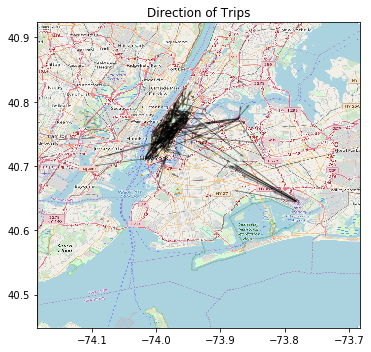

In [15]:

fig, ax = plt.subplots(figsize = (8,5))
ax.quiver(x_pos[::500],y_pos[::500],d_x[::500],d_y[::500], scale=1 , alpha=0.5, color='black')
ax.set_title('Direction of Trips')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'/quiver_diag.png')
plt.show()


Plot places that take longer time to reach. We filter out data, which are with duration in minutes of more than 25 min.

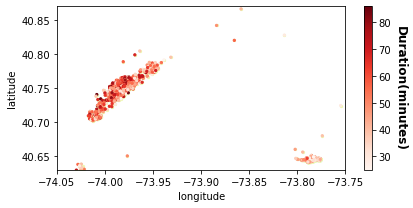

In [17]:
from matplotlib import cm


BBox = (-74.05, -73.75, 40.63, 40.87)
xmin,xmax,ymin,ymax = BBox[0],BBox[1],BBox[2],BBox[3]
x,y,dur = df_new.drop_long, df_new.drop_lat, df_new["Duration(min)"]


#get those trips, which are further than 25 minutes
Drop = list(zip(x,y,dur))
x1,y1,dur1 = [],[],[]
for i,j,k in Drop:   
    if k>=25:
        x1.append(i)
        y1.append(j)
        dur1.append(k)

fig, ax = plt.subplots(figsize = (6,3))
# ax.scatter(x0,y0, zorder=1, alpha= 0.3, c='b', s=0.3)
ax.scatter(x,y, zorder=1, alpha= 1, c='#edf8b1', s=5)
# ax.set_title('Plotting Dropoff Locations')

xx = np.ravel(x1); yy = np.ravel(y1) ; zz = np.ravel(dur1)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

plt.scatter(xx,yy,c=zz,cmap=cm.Reds,s=5)
cbar = plt.colorbar()
cbar.set_label("Duration(minutes)", labelpad=15,rotation=270, fontsize=12,fontweight='bold')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.tight_layout()
#plt.savefig('')
plt.show()


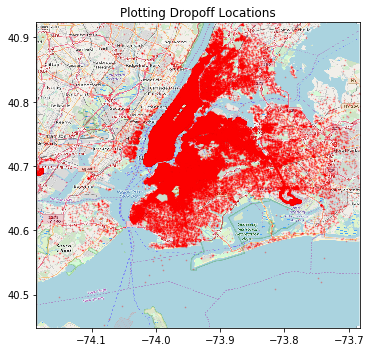

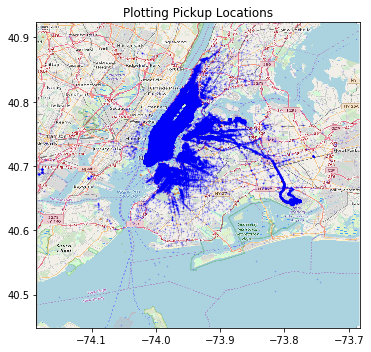

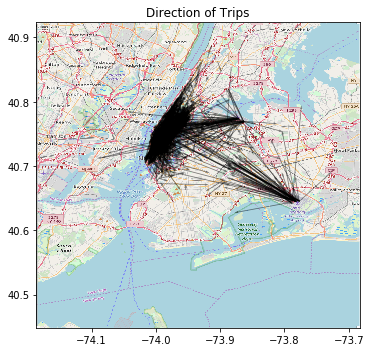

# Basic statistics for spatial analysis

We start with calculating  trip distance and trip duration distributions were calculated. For that we can use python `fitter` module.

In [19]:
from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.stats as sts

In [22]:
file_path = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/'
df = pd.read_csv(file_path+'dist_time.csv',sep=' ')

df.Duration = df.Duration/60

q1 = df["Duration"].quantile(0.25)
q3 = df["Duration"].quantile(0.75)

iqr = q3-q1

low_end = max(q1 - 1.5*iqr,0)
high_end = q3 + 1.5*iqr

#     print(low_end, high_end)

df_new = df[df["Duration"] <= high_end]


print("Distance")
print(df_new.Distance.describe())
print("Duration - Minutes")
print(df_new["Duration"].describe())
print('\n')

Distance
count    1.384424e+06
mean     2.912597e+00
std      3.294604e+00
min      0.000000e+00
25%      1.199000e+00
50%      1.993000e+00
75%      3.486000e+00
max      1.240510e+03
Name: Distance, dtype: float64
Duration - Minutes
count    1.384424e+06
mean     1.219504e+01
std      7.468468e+00
min      1.666667e-02
25%      6.400000e+00
50%      1.053333e+01
75%      1.651667e+01
max      3.486667e+01
Name: Duration, dtype: float64




In [ ]:
bins_dist = []
bins_time = []

bins_dist = np.linspace(0,100,100)

data = list(zip(df_new.Distance, df_new["Duration"]))

from collections import defaultdict
Distance_dist = defaultdict(int)

y = [i for i,j in data]

# CDF = [counts[0]]

# for i in range(1,len(counts)):

#     CDF.append(CDF[i-1] + counts[i])


fig, ax1 = plt.subplots()
left, bottom, width, height = [0.5, 0.4, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

counts,bins,_ = ax1.hist(y,bins=bins_dist,density=True)
ax1.plot(bins[:-1],counts, color='k')
ax1.set_xlim(0,35)
ax1.set_xlabel("Distance (kms)", fontsize = 15, fontweight= 'bold')
ax1.set_title("Trip Distance distribution", fontsize = 12, fontweight= 'bold')

ax2.plot(bins[:-1],np.cumsum(counts*(bins[1:]-bins[:-1])), color='green')
ax2.set_xlim(0,35)
ax2.set_xlabel("Distance (kms)", fontsize = 10, fontweight= 'bold')
ax2.set_title("CDF",fontsize = 10, fontweight= 'bold')
plt.tight_layout()
# plt.savefig('/home/user1/Documents/Data_Analysis/nyc-taxi-trip-duration/plots/data_distance_dist.pdf')
plt.show()